In [1]:
# Requirements:
# Reading images to an array
# Feature extraction (transform the image into a fixed-length feature vector)
# Apply any classifier to verify the performance

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import multiprocessing as mp
from tqdm import tqdm
import time

# For Perceptron
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
# For XGBoost
import xgboost as xgb
# For feature extraction: discrete wavelet transform
import pywt

### Reading images to an array

In [2]:
with open("./train.txt") as f:
    train_file_list = f.readlines()
train_file_list = [x.strip() for x in train_file_list]
with open("./val.txt") as f:
    val_file_list = f.readlines()
val_file_list = [x.strip() for x in val_file_list]
with open("./test.txt") as f:
    test_file_list = f.readlines()
test_file_list = [x.strip() for x in test_file_list]

train_file_list = [x.split(sep=" ") for x in train_file_list]
val_file_list = [x.split(sep=" ") for x in val_file_list]
test_file_list = [x.split(sep=" ") for x in test_file_list]

In [3]:
train_label = [int(x[1]) for x in train_file_list]
val_label = [int(x[1]) for x in val_file_list]
test_label = [int(x[1]) for x in test_file_list]

train_file_list = [x[0] for x in train_file_list]
val_file_list = [x[0] for x in val_file_list]
test_file_list = [x[0] for x in test_file_list]

In [4]:
print("# cpus: ", os.cpu_count())

# cpus:  64


In [5]:
NUM_PROCESSES = 8
# pool = mp.Pool(processes=NUM_PROCESSES)

In [6]:
def ReadImage(filePath):
    # image = cv2.imread(filePath, cv2.IMREAD_COLOR)
    image = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
    # image = cv2.resize(image, (256, 256))
    return image

In [7]:
with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_imgs = pool.map(ReadImage, tqdm(train_file_list))
    val_imgs = pool.map(ReadImage, tqdm(val_file_list))
    test_imgs = pool.map(ReadImage, tqdm(test_file_list))

100%|██████████| 450/450 [00:00<00:00, 553338.26it/s]


In [8]:
# the image size is different
for i in range(5):
    print(train_imgs[i].shape)

(256, 343)
(341, 256)
(256, 341)
(256, 341)
(341, 256)


In [9]:
# resize the images to 256x256
def ResizeImage(image):
    resized_img = cv2.resize(image, (256, 256))
    # resized_img = cv2.resize(image, (64, 64))
    return resized_img

In [10]:
with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(ResizeImage, tqdm(train_imgs))
    resized_val_imgs = pool.map(ResizeImage, tqdm(val_imgs))
    resized_test_imgs = pool.map(ResizeImage, tqdm(test_imgs))

100%|██████████| 450/450 [00:00<00:00, 4082.98it/s]


0-th image: 


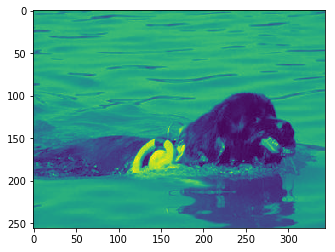

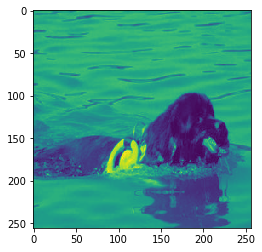

1-th image: 


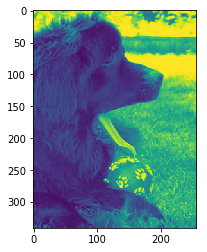

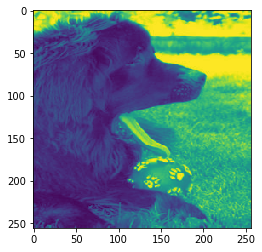

2-th image: 


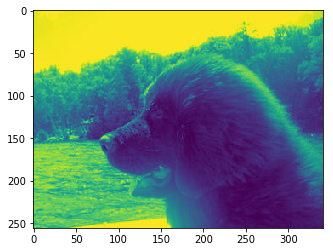

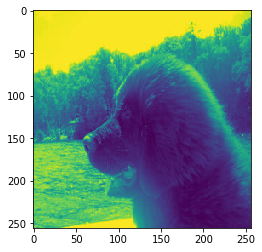

In [11]:
for i in range(3):
    print(f"{i}-th image: ")
    plt.imshow(train_imgs[i])
    plt.show();
    plt.imshow(resized_train_imgs[i])
    plt.show();

### Feature extraction (transform the image into a fixed-length feature vector)

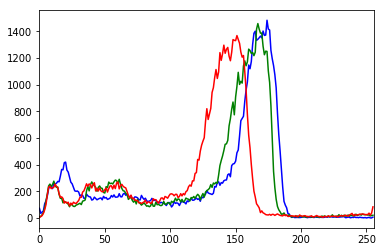

In [13]:
# color histogram
# method: opencv

color = ('b','g','r')
# plt.figure(figsize=(10, 8))
for i,col in enumerate(color):
    histr = cv2.calcHist(images=[resized_train_imgs[0]], channels=[i], mask=None, histSize=[256], ranges=[0,256])
    plt.plot(histr, color = col)
    plt.xlim([0, 256])
plt.show();

In [14]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist(images=[resized_train_imgs[0]], channels=[i], mask=None, histSize=[256], ranges=[0,256])
    print(histr.shape)

(256, 1)
(256, 1)
(256, 1)


In [15]:
resized_train_imgs[0].shape

(256, 256, 3)

In [16]:
resized_train_imgs[0][:, :, 0]

array([[175, 175, 173, ..., 162, 163, 162],
       [169, 170, 170, ..., 128, 120, 113],
       [161, 162, 167, ...,  89,  88,  89],
       ...,
       [157, 155, 158, ..., 131, 131, 130],
       [159, 158, 161, ..., 130, 130, 129],
       [161, 160, 163, ..., 133, 133, 132]], dtype=uint8)

b: 


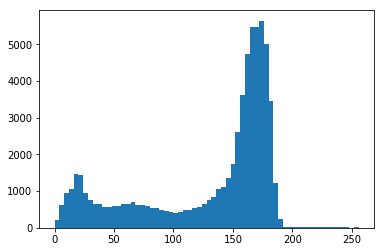

g: 


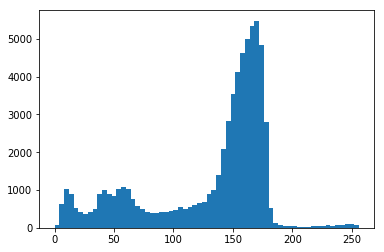

r: 


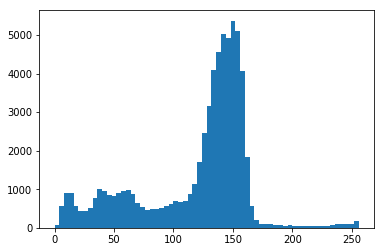

In [17]:
color = ('b', 'g', 'r')
for channel, col in enumerate(color):
    print(f"{col}: ")
    plt.hist(x=resized_train_imgs[0][:, :, channel].ravel(), bins=64, range=[0, 256]);
    plt.show()

In [18]:
# Ref.: https://github.com/Ixiaohuihuihui/Extract-color-histogram-feature/blob/master/rgb_feature.py
# extract rgb features

def ExtractColorHistFeatures(image):
    features = []
    for channel in range(3):
        hist = cv2.calcHist(images=[image], channels=[channel], mask=None, histSize=[64], ranges=[0,256])
        hist = cv2.normalize(hist, hist)
        # features.extend(hist)
        features.append(hist)
    return features

In [19]:
with mp.Pool(processes=NUM_PROCESSES) as pool:
    ### tqdm returns an iterator
    # train_features = pool.map(ExtractFeatures, tqdm(resized_train_imgs))
    # val_features = pool.map(ExtractFeatures, tqdm(resized_val_imgs))
    # test_features = pool.map(ExtractFeatures, tqdm(resized_test_imgs))
    train_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_train_imgs), total=len(resized_train_imgs)))
    val_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_val_imgs), total=len(resized_val_imgs)))
    test_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_test_imgs), total=len(resized_test_imgs)))

100%|██████████| 450/450 [00:00<00:00, 1611.28it/s]


In [20]:
train_features[0]

[array([[0.01439496],
        [0.04389751],
        [0.06791288],
        [0.07560919],
        [0.10361524],
        [0.10176242],
        [0.06812666],
        [0.05415927],
        [0.04532276],
        [0.04710431],
        [0.0409045 ],
        [0.04097576],
        [0.04275732],
        [0.04268606],
        [0.04575033],
        [0.04681927],
        [0.05066742],
        [0.0446814 ],
        [0.04346994],
        [0.04211596],
        [0.03833906],
        [0.03812528],
        [0.03541731],
        [0.03228178],
        [0.03007265],
        [0.02900372],
        [0.03021517],
        [0.03392081],
        [0.03498974],
        [0.03933673],
        [0.03969305],
        [0.04660548],
        [0.05387422],
        [0.05907636],
        [0.07461152],
        [0.07902978],
        [0.09670281],
        [0.12314108],
        [0.18535298],
        [0.25796917],
        [0.3379966 ],
        [0.38923413],
        [0.38994676],
        [0.40227512],
        [0.35688108],
        [0

In [21]:
# type(train_features)
np.array(train_features).shape

(63325, 3, 64, 1)

In [22]:
# flatten and reshape the features into (n_samples, n_features)
train_features = np.array(train_features)
val_features = np.array(val_features)
test_features = np.array(test_features)

def FlattenFeatures(feature):
    return feature.flatten()

with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_features = np.array(pool.map(FlattenFeatures, tqdm(train_features)))
    val_features = np.array(pool.map(FlattenFeatures, tqdm(val_features)))
    test_features = np.array(pool.map(FlattenFeatures, tqdm(test_features)))

100%|██████████| 450/450 [00:00<00:00, 55735.79it/s]


In [23]:
train_features.shape

(63325, 192)

### DWT

In [22]:
train_imgs[0].shape

(256, 343)

In [12]:
# try_imgs = cv2.cvtColor(src=resized_train_imgs[0], code=cv2.COLOR_BGR2GRAY)

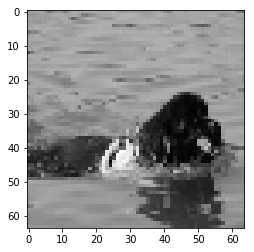

In [15]:
# plt.imshow(try_imgs, cmap='gray');

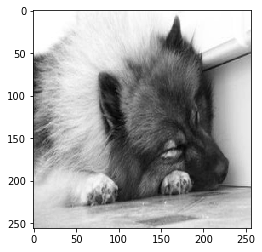

In [12]:
plt.imshow(resized_train_imgs[7483], cmap='gray');

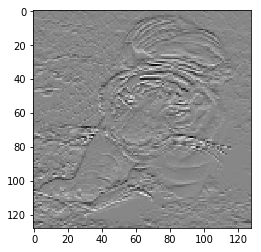

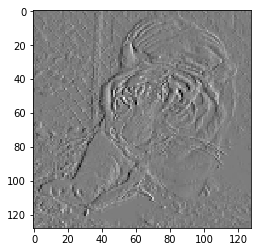

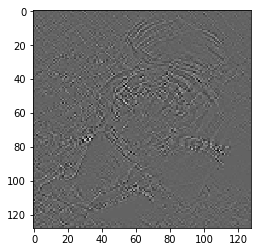

In [21]:
coeffs = pywt.dwt2(data=resized_val_imgs[330], wavelet='haar', mode='symmetric', axes=(0, 1))
# print(coeffs[0].shape)
# plt.imshow(coeffs[0]/np.abs(coeffs[0]).max(), cmap='gray');
# plt.show();
plt.imshow(coeffs[1][0]/np.abs(coeffs[1][0]).max(), cmap='gray');
plt.show();
plt.imshow(coeffs[1][1]/np.abs(coeffs[1][1]).max(), cmap='gray');
plt.show();
plt.imshow(coeffs[1][2]/np.abs(coeffs[1][2]).max(), cmap='gray');
plt.show();

In [14]:
# Discrete Wavelet Transform
def WaveletTransform(image):
    coeffs = pywt.dwt2(data=image, wavelet='haar', mode='symmetric', axes=(0, 1))
    # cA, (cH, cV, cD) = coeffs
    # _, (cH, cV, cD) = coeffs
    # cA, _ = coeffs
    _, (cH, cV, _) = coeffs
    return np.array([cH, cV])

In [15]:
def MultilevelDWT(image):
    coeffs = pywt.wavedec2(data=image, wavelet='haar', mode='symmetric', axes=(0, 1), level=4)
    cA4, (cH4, cV4, cD4), (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
    return np.array([cH4, cV4])

In [16]:
with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_features = pool.map(WaveletTransform, tqdm(resized_train_imgs))
    val_features = pool.map(WaveletTransform, tqdm(resized_val_imgs))
    test_features = pool.map(WaveletTransform, tqdm(resized_test_imgs))

train_features = np.array(train_features).reshape(len(train_features), -1)
val_features = np.array(val_features).reshape(len(val_features), -1)
test_features = np.array(test_features).reshape(len(test_features), -1)

100%|██████████| 450/450 [00:00<00:00, 1770.83it/s]


In [77]:
with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_features = pool.map(MultilevelDWT, tqdm(resized_train_imgs))
    val_features = pool.map(MultilevelDWT, tqdm(resized_val_imgs))
    test_features = pool.map(MultilevelDWT, tqdm(resized_test_imgs))

train_features = np.array(train_features).reshape(len(train_features), -1)
val_features = np.array(val_features).reshape(len(val_features), -1)
test_features = np.array(test_features).reshape(len(test_features), -1)

100%|██████████| 450/450 [00:00<00:00, 5757.87it/s]


In [78]:
train_features.shape

(63325, 256)

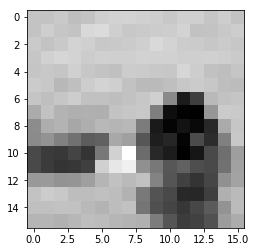

In [81]:
plt.imshow(train_features[0].reshape(16, 16), cmap='gray');

### Apply any classifier to verify the performance

#### Color Histogram 

In [24]:
## Perceptron
perceptron = Perceptron(n_jobs=8, random_state=42)
perceptron.fit(train_features, train_label)

Perceptron(n_jobs=8, random_state=42)

In [25]:
pred_train_label = perceptron.predict(train_features)
pred_val_label = perceptron.predict(val_features)
pred_test_label = perceptron.predict(test_features)

In [26]:
acc_train = accuracy_score(train_label, pred_train_label)
acc_val = accuracy_score(val_label, pred_val_label)
acc_test = accuracy_score(test_label, pred_test_label)

print(f"Accuracy of training set: {acc_train:.4f}")
print(f"Accuracy of validation set: {acc_val:.4f}")
print(f"Accuracy of testing set: {acc_test:.4f}")

Accuracy of training set: 0.0514
Accuracy of validation set: 0.0400
Accuracy of testing set: 0.0400


In [30]:
## Xgboost
# train the XGBoost model
dtrain = xgb.DMatrix(train_features, train_label)
dval = xgb.DMatrix(val_features, val_label)
dtest = xgb.DMatrix(test_features, test_label)

params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': 50,
    'max_depth': 12,
    'eta': 0.3,
    'nthread': 8
}
num_round = 10

model = xgb.train(
    params=params, 
    dtrain=dtrain, 
    num_boost_round=num_round
)

pred_train_label = model.predict(dtrain)
pred_val_label = model.predict(dval)
pred_test_label = model.predict(dtest)

acc_train = accuracy_score(train_label, pred_train_label)
acc_val = accuracy_score(val_label, pred_val_label)
acc_test = accuracy_score(test_label, pred_test_label)

print(f"Accuracy of training set: {acc_train:.4f}")
print(f"Accuracy of validation set: {acc_val:.4f}")
print(f"Accuracy of testing set: {acc_test:.4f}")

Accuracy of training set: 0.9682
Accuracy of validation set: 0.1200
Accuracy of testing set: 0.0867


In [ ]:
# NN

#### Wavelet Transform

In [44]:
## Perceptron
start_time = time.time()

perceptron = Perceptron(n_jobs=16, random_state=42)
perceptron.fit(train_features, train_label)

pred_train_label = perceptron.predict(train_features)
pred_val_label = perceptron.predict(val_features)
pred_test_label = perceptron.predict(test_features)

acc_train = accuracy_score(train_label, pred_train_label)
acc_val = accuracy_score(val_label, pred_val_label)
acc_test = accuracy_score(test_label, pred_test_label)

print(f"Accuracy of training set: {acc_train:.4f}")
print(f"Accuracy of validation set: {acc_val:.4f}")
print(f"Accuracy of testing set: {acc_test:.4f}")
print()
print(f"elapsed time: {time.time() - start_time} sec")

Accuracy of training set: 0.0391
Accuracy of validation set: 0.0356
Accuracy of testing set: 0.0244

elapsed time: 34.326889753341675 sec


In [51]:
## Perceptron
start_time = time.time()

perceptron = Perceptron(n_jobs=16, random_state=42)
perceptron.fit(train_features, train_label)

pred_train_label = perceptron.predict(train_features)
pred_val_label = perceptron.predict(val_features)
pred_test_label = perceptron.predict(test_features)

acc_train = accuracy_score(train_label, pred_train_label)
acc_val = accuracy_score(val_label, pred_val_label)
acc_test = accuracy_score(test_label, pred_test_label)

print(f"Accuracy of training set: {acc_train:.4f}")
print(f"Accuracy of validation set: {acc_val:.4f}")
print(f"Accuracy of testing set: {acc_test:.4f}")
print()
print(f"elapsed time: {time.time() - start_time} sec")

Accuracy of training set: 0.0381
Accuracy of validation set: 0.0156
Accuracy of testing set: 0.0222

elapsed time: 25.499085664749146 sec


In [82]:
## Perceptron
start_time = time.time()

perceptron = Perceptron(n_jobs=16, random_state=42)
perceptron.fit(train_features, train_label)

pred_train_label = perceptron.predict(train_features)
pred_val_label = perceptron.predict(val_features)
pred_test_label = perceptron.predict(test_features)

acc_train = accuracy_score(train_label, pred_train_label)
acc_val = accuracy_score(val_label, pred_val_label)
acc_test = accuracy_score(test_label, pred_test_label)

print(f"Accuracy of training set: {acc_train:.4f}")
print(f"Accuracy of validation set: {acc_val:.4f}")
print(f"Accuracy of testing set: {acc_test:.4f}")
print()
print(f"elapsed time: {time.time() - start_time} sec")

Accuracy of training set: 0.0373
Accuracy of validation set: 0.0333
Accuracy of testing set: 0.0289

elapsed time: 3.1897850036621094 sec


In [17]:
## Perceptron
start_time = time.time()

perceptron = Perceptron(n_jobs=16, random_state=42)
perceptron.fit(train_features, train_label)

pred_train_label = perceptron.predict(train_features)
pred_val_label = perceptron.predict(val_features)
pred_test_label = perceptron.predict(test_features)

acc_train = accuracy_score(train_label, pred_train_label)
acc_val = accuracy_score(val_label, pred_val_label)
acc_test = accuracy_score(test_label, pred_test_label)

print(f"Accuracy of training set: {acc_train:.4f}")
print(f"Accuracy of validation set: {acc_val:.4f}")
print(f"Accuracy of testing set: {acc_test:.4f}")
print()
print(f"elapsed time: {time.time() - start_time} sec")

Accuracy of training set: 0.9905
Accuracy of validation set: 0.0178
Accuracy of testing set: 0.0222

elapsed time: 1323.2923910617828 sec


In [47]:
## Xgboost
# train the XGBoost model
dtrain = xgb.DMatrix(train_features, train_label)
dval = xgb.DMatrix(val_features, val_label)
dtest = xgb.DMatrix(test_features, test_label)

params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': 50,
    'max_depth': 24,
    'eta': 0.3,
    'nthread': 32
}
num_round = 5

start_time = time.time()
model = xgb.train(
    params=params, 
    dtrain=dtrain, 
    num_boost_round=num_round
)

pred_train_label = model.predict(dtrain)
pred_val_label = model.predict(dval)
pred_test_label = model.predict(dtest)

acc_train = accuracy_score(train_label, pred_train_label)
acc_val = accuracy_score(val_label, pred_val_label)
acc_test = accuracy_score(test_label, pred_test_label)

print(f"Accuracy of training set: {acc_train:.4f}")
print(f"Accuracy of validation set: {acc_val:.4f}")
print(f"Accuracy of testing set: {acc_test:.4f}")
print()
print(f"elapsed time: {time.time() - start_time} sec")

Accuracy of training set: 0.9846
Accuracy of validation set: 0.0422
Accuracy of testing set: 0.0622

elapsed time: 171.99649620056152 sec


In [53]:
## Xgboost
# train the XGBoost model
dtrain = xgb.DMatrix(train_features, train_label)
dval = xgb.DMatrix(val_features, val_label)
dtest = xgb.DMatrix(test_features, test_label)

params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': 50,
    'max_depth': 12,
    'eta': 0.3,
    'nthread': 32
}
num_round = 5

start_time = time.time()
model = xgb.train(
    params=params, 
    dtrain=dtrain, 
    num_boost_round=num_round
)

pred_train_label = model.predict(dtrain)
pred_val_label = model.predict(dval)
pred_test_label = model.predict(dtest)

acc_train = accuracy_score(train_label, pred_train_label)
acc_val = accuracy_score(val_label, pred_val_label)
acc_test = accuracy_score(test_label, pred_test_label)

print(f"Accuracy of training set: {acc_train:.4f}")
print(f"Accuracy of validation set: {acc_val:.4f}")
print(f"Accuracy of testing set: {acc_test:.4f}")
print()
print(f"elapsed time: {time.time() - start_time} sec")

Accuracy of training set: 0.8586
Accuracy of validation set: 0.0444
Accuracy of testing set: 0.0533

elapsed time: 86.59678387641907 sec


In [83]:
## Xgboost
# train the XGBoost model
dtrain = xgb.DMatrix(train_features, train_label)
dval = xgb.DMatrix(val_features, val_label)
dtest = xgb.DMatrix(test_features, test_label)

params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': 50,
    'max_depth': 12,
    'eta': 0.3,
    'nthread': 32
}
num_round = 5

start_time = time.time()
model = xgb.train(
    params=params, 
    dtrain=dtrain, 
    num_boost_round=num_round
)

pred_train_label = model.predict(dtrain)
pred_val_label = model.predict(dval)
pred_test_label = model.predict(dtest)

acc_train = accuracy_score(train_label, pred_train_label)
acc_val = accuracy_score(val_label, pred_val_label)
acc_test = accuracy_score(test_label, pred_test_label)

print(f"Accuracy of training set: {acc_train:.4f}")
print(f"Accuracy of validation set: {acc_val:.4f}")
print(f"Accuracy of testing set: {acc_test:.4f}")
print()
print(f"elapsed time: {time.time() - start_time} sec")

Accuracy of training set: 0.8303
Accuracy of validation set: 0.0711
Accuracy of testing set: 0.0778

elapsed time: 85.34685206413269 sec


In [18]:
## Xgboost
# train the XGBoost model
dtrain = xgb.DMatrix(train_features, train_label)
dval = xgb.DMatrix(val_features, val_label)
dtest = xgb.DMatrix(test_features, test_label)

params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': 50,
    'max_depth': 12,
    'eta': 0.3,
    'nthread': 32
}
num_round = 5

start_time = time.time()
model = xgb.train(
    params=params, 
    dtrain=dtrain, 
    num_boost_round=num_round
)

pred_train_label = model.predict(dtrain)
pred_val_label = model.predict(dval)
pred_test_label = model.predict(dtest)

acc_train = accuracy_score(train_label, pred_train_label)
acc_val = accuracy_score(val_label, pred_val_label)
acc_test = accuracy_score(test_label, pred_test_label)

print(f"Accuracy of training set: {acc_train:.4f}")
print(f"Accuracy of validation set: {acc_val:.4f}")
print(f"Accuracy of testing set: {acc_test:.4f}")
print()
print(f"elapsed time: {time.time() - start_time} sec")

Accuracy of training set: 0.8718
Accuracy of validation set: 0.0489
Accuracy of testing set: 0.0556

elapsed time: 2262.408310174942 sec
